# Week 8 Supervised Learning

## Practicum 8-1

PR8-1: Regressiemodellen in Machine Learning. Great Outdoors wil graag weten hoeveel zij gaat verkopen op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Je doet dus het volgende met de reeds bekende data:

* Bedenk met welke onafhankelijke variabelen, die ook uit meerdere databasetabellen kunnen komen, dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
* Pas waar nodig Dummy Encoding toe.
* Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
* Train het regressiemodel.
* Evalueer de performance van je getrainde regressiemodel.

### Tabels 1/2

Hieronder zie je de tabellen die we gaan gebruiken voor deze practicumopdracht van 8-1.

In [172]:
# age_group
# sales_demographic
# sales_territory

# order_details
# order_header
# order_method

# product
# product_line
# product_type

# sales_branch
# SALES_TARGETData

### Imports

Hier staan alle imports die gebruikt zullen worden voor de practicumopdrachten 8-1 en 8-2.

In [173]:
import sqlite3 as sql
import warnings as warn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
#from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier

from typing import Any
warn.filterwarnings("ignore")

### SQLite connections and CSV-files

Hier maken we de connectie naar de SQLite Databases en roepen we de CSV bestanden aan.

In [174]:
conn1 = sql.connect("Great_Outdoors_Data_SQLite/go_crm.sqlite")
conn2 = sql.connect("Great_Outdoors_Data_SQLite/go_sales.sqlite")
conn3 = sql.connect("Great_Outdoors_Data_SQLite/go_staff.sqlite")

go_sales_inventory_levelsdata = pd.read_csv("Great_Outdoors_Data_SQLite/GO_SALES_INVENTORY_LEVELSData.csv")
go_sales_product_forecastdata = pd.read_csv("Great_Outdoors_Data_SQLite/GO_SALES_PRODUCT_FORECASTData.csv")

### Check all tables

Hieronder wordt gecheckt welke tabellen er nou in Python zitten.

In [175]:
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', '_i2', '_i3', 'sql', 'warn', 'pd', 'plt', 'np', 'train_test_split', 'LinearRegression', 'mean_squared_error', 'mean_absolute_error', 'accuracy_score', 'RandomForestClassifier', 'tree', 'metrics', 'DecisionTreeClassifier', 'Any', '_i4', 'conn1', 'conn2', 'conn3', 'go_sales_inventory_levelsdata', 'go_sales_product_forecastdata', '_i5', '_i6', '__annotations__', 'i', 'conn', 'tables', 'table', 'age_group0', 'country0', 'retailer0', 'retailer_contact0', 'retailer_headquarters0', 'retailer_segment0', 'retailer_site0', 'retailer_type0', 'sales_demographic0', 'sales_territory0', 'country1', 'order_details1', 'order_header1', 'order_method1', 'product1', 'product_line1', 'product_type1', 'retailer_site1', 'return_reason1', 'returned_item1', 'sales_bra

### Check all tables of the SQLite databases.

Hier checken we alle DataFrames van de tabellen voor een snel overzicht.

In [176]:
# Iterate over all tables from the conns.
for i, conn in enumerate([conn1, conn2, conn3]):
    tables: list[Any] = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

    for table in tables:
        globals()[table[0] + str(i)] = pd.read_sql_query(f"SELECT * FROM {table[0]}", conn)
        print(globals()[table[0] + str(i)])

  AGE_GROUP_CODE UPPER_AGE LOWER_AGE TRIAL219
0              1        20         0        T
1              2        30        21        T
2              3        40        31        T
3              4        50        41        T
4              5        60        51        T
5              6        70        61        T
   COUNTRY_CODE      COUNTRY_EN FLAG_IMAGE SALES_TERRITORY_CODE TRIAL219
0             1          France        F01                    6        T
1            10          Sweden        F10                    5        T
2            11           Japan        F11                    4        T
3            12          Taiwan        F12                    4        T
4            13           Korea        F13                    4        T
5            14           China        F14                    4        T
6            16       Australia        F15                    4        T
7            17         Belgium        F16                    6        T
8            18      

          Id SALES_STAFF_CODE SALES_YEAR SALES_PERIOD  \
0          1                6       2021            5   
1          2                6       2021            5   
2          3                6       2021            5   
3          4                6       2021            5   
4          5                6       2021            5   
...      ...              ...        ...          ...   
39525  39526               83       2020            8   
39526  39527               83       2021            3   
39527  39528               83       2021            3   
39528  39529               83       2021            3   
39529  39530               83       2021            3   

                 RETAILER_NAME PRODUCT_NUMBER SALES_TARGET RETAILER_CODE  \
0           Altitudes extrêmes             53          489            33   
1           Altitudes extrêmes             55          666            33   
2           Altitudes extrêmes             56          682            33   
3          

### For quick testing the necassery tables

We kunnen snel de inhoud zien van de tabellen.

In [177]:
test = pd.read_sql_query(f"SELECT * FROM SALES_TARGETData", conn2)
test

# TRIAL column not taken into account
# age_group => 3 columns
# sales_demographic => 4 columns
# sales_territory => 2 columns
# 9 columns

# order_details => 7 columns
# order_header => 8 columns
# order_method => 2 columns
# 17 columns

# product => 9 columns
# product_line => 2 columns
# product_type => 3 columns
# 14 columns

# sales_branch => 7 columns
# SALES_TARGETData => 8 columns
# 15 columns
# 55 columns in total - 10 columns = 45 columns

,Id,SALES_STAFF_CODE,SALES_YEAR,SALES_PERIOD,RETAILER_NAME,PRODUCT_NUMBER,SALES_TARGET,RETAILER_CODE,TRIAL888
0,1,6,2021,5,Altitudes extrêmes,53,489,33,T
1,2,6,2021,5,Altitudes extrêmes,55,666,33,T
2,3,6,2021,5,Altitudes extrêmes,56,682,33,T
3,4,6,2021,5,Camping Sauvage,76,3193,35,T
4,5,6,2021,5,Camping Sauvage,85,7236,35,T
...,...,...,...,...,...,...,...,...,...
39525,39526,83,2020,8,Golf Shop Jiro,107,4683,129,T
39526,39527,83,2021,3,Japan Sports Youhinten,33,497,130,T
39527,39528,83,2021,3,Kitanaka Tozanyouhinten,43,1564,133,T
39528,39529,83,2021,3,Kitanaka Tozanyouhinten,60,600,133,T


### Tables 2/2

Tabellen die we gaan gebruiken voor het trainen en testen van de data voor opdracht 8-1.

In [178]:
# Remove tables that we not gonna use.
go_tables: list[str] = ["age_group0", "sales_demographic0", "sales_territory0", "order_details1", "order_header1", 
    "order_method1", "product1", "product_line1", "product_type1", "sales_branch1", "SALES_TARGETData1"
]

### Merge the tables

Hier voegen we de tabellen samen, zodat we betere voorspellingen kunnen maken.

In [179]:
def go_merge(go_table: Any):
    df_merge: list[Any] = [globals()[table] for table in go_table]
    merged_df = pd.concat(df_merge, ignore_index=True)

    return merged_df

### Drop unnecassary columns 1/2

Hier verwijderen we de nutteloze TRIAL kolommen.

In [180]:
trial = go_merge(go_tables)
df = trial[trial.columns.drop(list(trial.filter(regex="TRIAL")))]

### Show all the columns

We tonen alle kolommen en filteren de lege waardes eruit bij de volgende stap.

In [181]:
#Here we display all the columns
pd.set_option("display.max_columns", None)
df

,AGE_GROUP_CODE,UPPER_AGE,LOWER_AGE,DEMOGRAPHIC_CODE,RETAILER_CODEMR,SALES_PERCENT,SALES_TERRITORY_CODE,TERRITORY_NAME_EN,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_METHOD_EN,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,PRODUCT_LINE_CODE,PRODUCT_LINE_EN,PRODUCT_TYPE_EN,ADDRESS1,ADDRESS2,CITY,REGION,POSTAL_ZONE,COUNTRY_CODE,Id,SALES_YEAR,SALES_PERIOD,SALES_TARGET,RETAILER_CODE
0,1,20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,30,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,40,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,50,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,60,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107,NaN,NaN,NaN,NaN,Golf Shop Jiro,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39526.0,2020,8,4683,129
90620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,NaN,NaN,NaN,NaN,Japan Sports Youhinten,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39527.0,2021,3,497,130
90621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,NaN,NaN,NaN,NaN,Kitanaka Tozanyouhinten,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39528.0,2021,3,1564,133
90622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,NaN,Kitanaka Tozanyouhinten,NaN,NaN,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39529.0,2021,3,600,133


### Delete unnecassary columns 2/2

Hier verwijderen we kolommen die geen waarde hebben op het regressiemodel.

In [182]:
df = df.drop(columns=[
    "RETAILER_NAME", "ADDRESS1", "ADDRESS2", "CITY", "REGION", "POSTAL_ZONE", "PRODUCT_IMAGE", "PRODUCT_NAME", "DESCRIPTION",
    "TERRITORY_NAME_EN", "ORDER_METHOD_EN", "LANGUAGE", "PRODUCT_LINE_EN", "PRODUCT_TYPE_EN"
])
df = df.fillna(0)
df

,AGE_GROUP_CODE,UPPER_AGE,LOWER_AGE,DEMOGRAPHIC_CODE,RETAILER_CODEMR,SALES_PERCENT,SALES_TERRITORY_CODE,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_LINE_CODE,COUNTRY_CODE,Id,SALES_YEAR,SALES_PERIOD,SALES_TARGET,RETAILER_CODE
0,1,20,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
1,2,30,21,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
2,3,40,31,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
3,4,50,41,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
4,5,60,51,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90619,0,0,0,0,0,0,0,0,0,107,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39526.0,2020,8,4683,129
90620,0,0,0,0,0,0,0,0,0,33,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39527.0,2021,3,497,130
90621,0,0,0,0,0,0,0,0,0,43,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39528.0,2021,3,1564,133
90622,0,0,0,0,0,0,0,0,0,60,0.0,0,0,0,0,0,83,0,0,0,0,0,0,0,0,0,39529.0,2021,3,600,133


### Convert the columns to numeric types

Alle kolommen worden naar numerieke waardes omgezet, zodat ze bruikbaar zijn voor de regressiemodellen.

In [183]:
# Convert all remaining columns to numeric types
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")

### Horizontal and vertical cut

We snijden horizontaal en verticaal, zodat we het model kunnen trainen en testen. Ook vullen we defaults in voor X.

In [184]:
X = df.drop(columns=["SALES_PERCENT"])
y = df["SALES_PERCENT"]
X = X.fillna(0)
X

,AGE_GROUP_CODE,UPPER_AGE,LOWER_AGE,DEMOGRAPHIC_CODE,RETAILER_CODEMR,SALES_TERRITORY_CODE,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_LINE_CODE,COUNTRY_CODE,Id,SALES_YEAR,SALES_PERIOD,SALES_TARGET,RETAILER_CODE
0,1,20,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
1,2,30,21,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
2,3,40,31,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
3,4,50,41,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
4,5,60,51,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90619,0,0,0,0,0,0,0,0,107,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39526.0,2020,8,4683,129
90620,0,0,0,0,0,0,0,0,33,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39527.0,2021,3,497,130
90621,0,0,0,0,0,0,0,0,43,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39528.0,2021,3,1564,133
90622,0,0,0,0,0,0,0,0,60,0.0,0.0,0.0,0.0,0,0,83,0,0.0,0,0.0,0,0.0,0.0,0,0,39529.0,2021,3,600,133


### Train and test data

Hier kunnen we eindelijk de data trainen en testen die we nodig hebben.

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model: LinearRegression = LinearRegression()
model.fit(X_train, y_train)
model

LinearRegression()

### Predict the model

We kunnen het model met de test data van de onafhankelijke waarde voorspellen.

In [186]:
y_pred = model.predict(X_test)
y_pred

array([ 0.94418723, -0.12738267,  0.85285252, ...,  1.15602694,
        0.76804381,  0.23274776])

### Get a new predicted column

We maken een nieuwe kolom aan met een nieuwe naam die we met het oude kolom kunnen vergelijken.

In [187]:
df_pred = pd.DataFrame(y_pred)
df_pred = df_pred.rename(columns={0: "PREDICTED_SALES_PERCENT"})
df_pred

,PREDICTED_SALES_PERCENT
0,0.944187
1,-0.127383
2,0.852853
3,0.154182
4,0.535235
...,...
13589,0.064345
13590,1.058851
13591,1.156027
13592,0.768044


### Concat old column with new column

We vergelijken beide kolommen door ze samen te voegen.

In [188]:
y_test_merge = pd.concat([y_test.reset_index()["SALES_PERCENT"], df_pred], axis=1)
y_test_merge.loc[y_test_merge["PREDICTED_SALES_PERCENT"].notna(), :]

,SALES_PERCENT,PREDICTED_SALES_PERCENT
0,0,0.944187
1,0,-0.127383
2,0,0.852853
3,0,0.154182
4,0,0.535235
...,...,...
13589,0,0.064345
13590,0,1.058851
13591,0,1.156027
13592,0,0.768044


### Show the predictions for the columns

Met Matplotlib kunnen we wederom weer in een grafiek de tabellen met elkaar vergelijken en voorspellen.

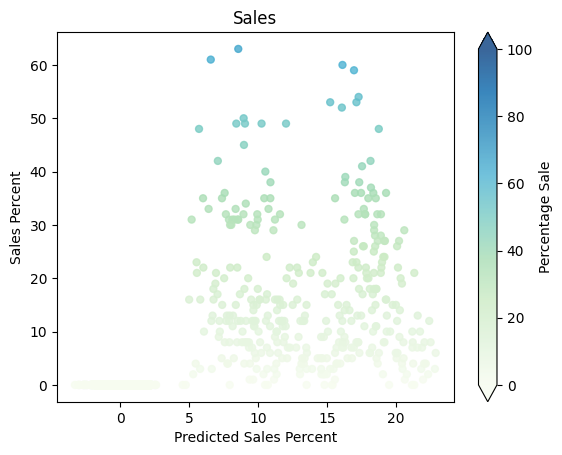

In [189]:
colors = np.interp(y_test_merge["SALES_PERCENT"], (y_test_merge["SALES_PERCENT"].min(), y_test_merge["SALES_PERCENT"].max()), (0, 66))

plt.xlabel("Predicted Sales Percent")
plt.ylabel("Sales Percent")
plt.title("Sales")
plt.scatter(x=y_test_merge["PREDICTED_SALES_PERCENT"], y=y_test_merge["SALES_PERCENT"], s=25, c=colors, cmap="GnBu", alpha=0.8)
plt.colorbar(orientation="vertical", label="Percentage Sale", extend="both")
plt.clim(0, 100)
plt.show()

### Measure mean errors for squared and absolute

We berekenen voor beide squared en absolute de error, zodat we kunnen zien hoe goed het model werkt.

In [190]:
mean_squared_error(y_test_merge["SALES_PERCENT"], y_test_merge["PREDICTED_SALES_PERCENT"])

5.674171857133748

In [191]:
mean_absolute_error(y_test_merge["SALES_PERCENT"], y_test_merge["PREDICTED_SALES_PERCENT"])

0.6049420499003197

## Practicum 8-2

PR8-2: Classificatiemodellen in Machine Learning. Great Outdoors wil graag weten wat de retourredenen gaan zijn op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Let op: de retourreden kan ook "n.v.t." zijn, niet elke order wordt namelijk geretourneerd; je zult dit moeten aanpakken door een join tussen "returned_item" en "order_details". Je doet dus het volgende met de reeds bekende data:

* Bedenk met welke onafhankelijke variabelen dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
* Pas waar nodig Dummy Encoding toe.
* Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
* Train het classificatiemodel.
* Evalueer de performance van je getrainde classificatiemodel a.d.h.v. een confusion matrix.


### Tables to use for the classification model

De tabellen die we gebruiken voor het classificatie model die we ook snel kunnen uitlezen.

In [192]:
# return_reason
# returned_item
# order_details

return_reason = pd.read_sql_query(f"SELECT * FROM return_reason", conn2)
returned_item = pd.read_sql_query(f"SELECT * FROM returned_item", conn2)
order_details = pd.read_sql_query(f"SELECT * FROM order_details", conn2)
returned_item

# TRIAL column not taken into account
# return_reason => 2 columns
# returned_item => 5 columns
# order_details => 7 columns
# 14 columns

,RETURN_CODE,RETURN_DATE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,TRIAL888
0,1491,1-8-2021 04:10:24,84858,5,8,T
1,1492,6-12-2020 18:46:19,84440,2,2,T
2,1493,24-6-2021 09:23:14,84867,4,22,T
3,1494,21-7-2021 00:00:09,84873,3,20,T
4,1496,7-10-2020 05:13:58,84488,1,2,T
...,...,...,...,...,...,...
701,2465,6-6-2021 09:22:12,114972,3,24,T
702,2466,6-10-2021 12:31:25,114983,5,66,T
703,2467,31-3-2022 15:39:38,115215,4,64,T
704,2468,23-12-2022 19:48:50,115171,1,2,T


### Merging the used tables together

We zullen hier alle tabellen samenvoegen om dit te kunnen gebruiken voor het model en we vegen de TRIAL kolommen schoon.

In [193]:
df = returned_item.merge(order_details, how="outer", on="ORDER_DETAIL_CODE").merge(return_reason, how="outer", on="RETURN_REASON_CODE")
df = df[df.columns.drop(list(df.filter(regex="TRIAL")))]
df = df.dropna()
df

,RETURN_CODE,RETURN_DATE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_DESCRIPTION_EN
0,2298,14-12-2021 11:28:50,100250,1,6,9254,43,52,126.51,189.77,189.77,Defective product
1,2302,6-9-2021 17:43:14,100653,1,4,8483,113,36,6.01,12.05,12.05,Defective product
2,1972,4-9-2022 03:07:48,100698,1,2,8495,7,20,46.38,64,56.95,Defective product
3,1978,23-8-2022 02:04:44,100750,1,2,8498,18,40,86,129,111.8,Defective product
4,1984,15-8-2022 13:33:58,100835,1,4,8492,40,56,17.97,25,22.19,Defective product
...,...,...,...,...,...,...,...,...,...,...,...,...
701,1961,13-7-2021 17:43:43,98314,5,86,8206,77,86,45.31,90.63,90.63,Unsatisfactory product
702,1914,15-4-2022 13:32:28,98631,5,164,8239,4,164,5,7,7,Unsatisfactory product
703,1918,25-4-2022 22:56:33,98653,5,22,8239,6,22,85.11,120,120,Unsatisfactory product
704,1932,10-4-2022 15:38:36,98962,5,112,8239,33,112,18,27,27,Unsatisfactory product


### Convert the return date to a string

We moeten de retourdatum converteren naar een string, want anders werkt het plotten niet.

In [194]:
df["RETURN_DATE"] = df["RETURN_DATE"].to_string()
df = df.drop(columns=["RETURN_DATE"])
df

,RETURN_CODE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_DESCRIPTION_EN
0,2298,100250,1,6,9254,43,52,126.51,189.77,189.77,Defective product
1,2302,100653,1,4,8483,113,36,6.01,12.05,12.05,Defective product
2,1972,100698,1,2,8495,7,20,46.38,64,56.95,Defective product
3,1978,100750,1,2,8498,18,40,86,129,111.8,Defective product
4,1984,100835,1,4,8492,40,56,17.97,25,22.19,Defective product
...,...,...,...,...,...,...,...,...,...,...,...
701,1961,98314,5,86,8206,77,86,45.31,90.63,90.63,Unsatisfactory product
702,1914,98631,5,164,8239,4,164,5,7,7,Unsatisfactory product
703,1918,98653,5,22,8239,6,22,85.11,120,120,Unsatisfactory product
704,1932,98962,5,112,8239,33,112,18,27,27,Unsatisfactory product


### Create dummies for the return description

We zullen dummies maken van de retourbeschrijving, zodat we meer gegevens hebben.

In [195]:
df_dummies = pd.get_dummies(df.loc[:, ["RETURN_DESCRIPTION_EN"]])
df_dummies

,RETURN_DESCRIPTION_EN_Defective product,RETURN_DESCRIPTION_EN_Incomplete product,RETURN_DESCRIPTION_EN_Unsatisfactory product,RETURN_DESCRIPTION_EN_Wrong product ordered,RETURN_DESCRIPTION_EN_Wrong product shipped
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
701,False,False,True,False,False
702,False,False,True,False,False
703,False,False,True,False,False
704,False,False,True,False,False


### Add the dummy columns to the DataFrame

Hier voegen we de dummy kolommen toe aan het DataFrame.

In [196]:
df = pd.concat([df, df_dummies], axis=1)
#df = df.drop(columns=["RETURN_DESCRIPTION_EN"], axis=1)
df

,RETURN_CODE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_DESCRIPTION_EN,RETURN_DESCRIPTION_EN_Defective product,RETURN_DESCRIPTION_EN_Incomplete product,RETURN_DESCRIPTION_EN_Unsatisfactory product,RETURN_DESCRIPTION_EN_Wrong product ordered,RETURN_DESCRIPTION_EN_Wrong product shipped
0,2298,100250,1,6,9254,43,52,126.51,189.77,189.77,Defective product,True,False,False,False,False
1,2302,100653,1,4,8483,113,36,6.01,12.05,12.05,Defective product,True,False,False,False,False
2,1972,100698,1,2,8495,7,20,46.38,64,56.95,Defective product,True,False,False,False,False
3,1978,100750,1,2,8498,18,40,86,129,111.8,Defective product,True,False,False,False,False
4,1984,100835,1,4,8492,40,56,17.97,25,22.19,Defective product,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,1961,98314,5,86,8206,77,86,45.31,90.63,90.63,Unsatisfactory product,False,False,True,False,False
702,1914,98631,5,164,8239,4,164,5,7,7,Unsatisfactory product,False,False,True,False,False
703,1918,98653,5,22,8239,6,22,85.11,120,120,Unsatisfactory product,False,False,True,False,False
704,1932,98962,5,112,8239,33,112,18,27,27,Unsatisfactory product,False,False,True,False,False


### Drop the return description and put it to the test data and horizontal/vertical cut

We zullen de retourredenen verwijderen en de dummy data gebruiken voor het testen. Hier wordt horizontaal en verticaal gesneden.

In [197]:
#"RETURN_DESCRIPTION_EN_Defective product", "RETURN_DESCRIPTION_EN_Incomplete product", "RETURN_DESCRIPTION_EN_Unsatisfactory product", "RETURN_DESCRIPTION_EN_Wrong product ordered", "RETURN_DESCRIPTION_EN_Wrong product shipped"
X = df.drop(columns=["RETURN_DESCRIPTION_EN"])
y = df[["RETURN_DESCRIPTION_EN"]]
y

,RETURN_DESCRIPTION_EN
0,Defective product
1,Defective product
2,Defective product
3,Defective product
4,Defective product
...,...
701,Unsatisfactory product
702,Unsatisfactory product
703,Unsatisfactory product
704,Unsatisfactory product


### Train and test the model

Hieronder zullen we voor de juiste data het model trainen en testen.

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
list(X.columns)

['RETURN_CODE',
 'ORDER_DETAIL_CODE',
 'RETURN_REASON_CODE',
 'RETURN_QUANTITY',
 'ORDER_NUMBER',
 'PRODUCT_NUMBER',
 'QUANTITY',
 'UNIT_COST',
 'UNIT_PRICE',
 'UNIT_SALE_PRICE',
 'RETURN_DESCRIPTION_EN_Defective product',
 'RETURN_DESCRIPTION_EN_Incomplete product',
 'RETURN_DESCRIPTION_EN_Unsatisfactory product',
 'RETURN_DESCRIPTION_EN_Wrong product ordered',
 'RETURN_DESCRIPTION_EN_Wrong product shipped']

### A tree with a max depth

Hieronder is een grafiek waarin je de maximale diepte kan inzien.

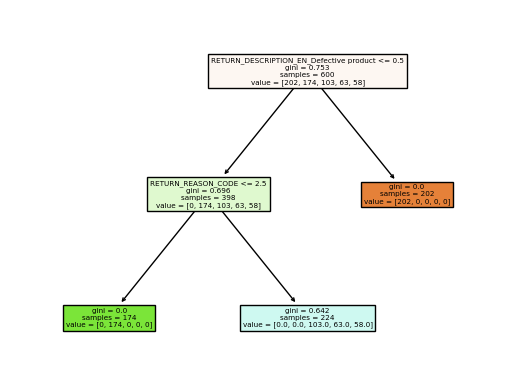

In [199]:
model: DecisionTreeClassifier = DecisionTreeClassifier(max_depth=2, random_state=0)
model.fit(X_train, y_train)
tree.plot_tree(model, feature_names=X.columns, filled=True)
plt.show()

### Test data to DataFrame and renamed

Hier zullen we de onafhankelijk test data naar een DataFrame omzetten en de kolom hernoemen.

In [200]:
df_pred = pd.DataFrame(model.predict(X_test))
df_pred = df_pred.rename(columns={0: "PREDICTED_RETURN_DESCRIPTION_EN"})
frame = pd.concat([y_test.reset_index()["RETURN_DESCRIPTION_EN"], df_pred], axis=1)
frame

,RETURN_DESCRIPTION_EN,PREDICTED_RETURN_DESCRIPTION_EN
0,Wrong product ordered,Unsatisfactory product
1,Defective product,Defective product
2,Defective product,Defective product
3,Defective product,Defective product
4,Incomplete product,Incomplete product
...,...,...
101,Incomplete product,Incomplete product
102,Defective product,Defective product
103,Defective product,Defective product
104,Wrong product ordered,Unsatisfactory product


### Confusion Matrix

We hebben hier een afbeelding met een Confusion Matrix, zodat er snel voorspellingen kunnen worden gemaakt

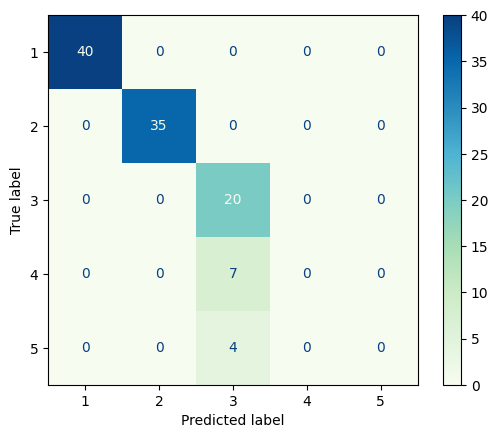

In [202]:
matrix = metrics.confusion_matrix(y_test, model.predict(X_test))
display: metrics.ConfusionMatrixDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["1", "2", "3", "4", "5"])
display.plot(cmap="GnBu")
plt.show()

### Test the accuracy score

We kunnen nu meten hoe goed het model het heeft gedaan.

In [203]:
print(accuracy_score(frame["RETURN_DESCRIPTION_EN"], frame["PREDICTED_RETURN_DESCRIPTION_EN"]))

0.8962264150943396
